# Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [3]:
read_random = True

In [4]:
f_suffix = ('r' if read_random else 'nr')
train_data = pd.read_csv('train_' + f_suffix + '.csv').set_index('Unnamed: 0')
val_data = pd.read_csv('val_' + f_suffix + '.csv').set_index('Unnamed: 0')
test_data = pd.read_csv('test_' + f_suffix + '.csv').set_index('Unnamed: 0')

In [5]:
list_TFI_questions = [
    'Plec', 'Wiek [lata]', 'Wyksztalcenie', 'Stan cywilny',
    'TFI6', 'TFI7', 'TFI8', 'TFI9.1', 'TFI9.2', 'TFI9.3', 'TFI9.4',
    'TFI9.5', 'TFI9.6', 'TFI10', 'TFI11', 'TFI12', 'TFI13', 'TFI14',
    'TFI15', 'TFI16', 'TFI17', 'TFI18', 'TFI19', 'TFI20', 'TFI21', 'TFI22',
    'TFI23', 'TFI24', 'TFI25'
]


# Define inputs and outputs

In [6]:
list_outputs = ['Zespol kruchosci']
list_inputs = [
    'TFI11', 'TFI12', 'TFI13', 'TFI14', 'TFI15', 'TFI16', 'TFI17', 
    'TFI18', 'TFI19', 'TFI20', 'TFI21', 'TFI22', 'TFI23', 'TFI24',
    'TFI25'
]
print(list_inputs)
print(list_outputs)

['TFI11', 'TFI12', 'TFI13', 'TFI14', 'TFI15', 'TFI16', 'TFI17', 'TFI18', 'TFI19', 'TFI20', 'TFI21', 'TFI22', 'TFI23', 'TFI24', 'TFI25']
['Zespol kruchosci']


# Machine Learning Training

## General function for SkLearn models

In [7]:
def train_and_get_model_metrics(model, x_train, y_train, x_val, y_val, weights=None):
    if weights is None:
        model.fit(x_train, y_train)
    else:
        model.fit(x_train, y_train, sample_weight=weights.values)
    
    y_train_pred = (pd.Series(model.predict(x_train), index=y_train.index) > 0.5).astype('int')
    tpr_train = np.round((y_train_pred[y_train > 0.5] == 1).astype('float').mean(), 2)
    tnr_train = np.round((y_train_pred[y_train < 0.5] == 0).astype('float').mean(), 2)
    precision = (y_train_pred.where(y_train > 0.5)).sum() / y_train_pred.sum()
    recall = (y_train_pred.where(y_train > 0.5)).sum() / y_train.sum()
    f1_train = np.round(2*(precision*recall) / (precision+recall), 2)

    y_val_pred = (pd.Series(model.predict(x_val), index=y_val.index) > 0.5).astype('int')
    tpr_val = np.round((y_val_pred[y_val > 0.5] == 1).astype('float').mean(), 2)
    tnr_val = np.round((y_val_pred[y_val < 0.5] == 0).astype('float').mean(), 2)
    precision = (y_val_pred.where(y_val > 0.5)).sum() / y_val_pred.sum()
    recall = (y_val_pred.where(y_val > 0.5)).sum() / y_val.sum()
    f1_val = np.round(2*(precision*recall) / (precision+recall), 2)

    metrics = pd.Series({
        'tpr_train': tpr_train, 'tnr_train': tnr_train, 'tpr_val': tpr_val, 'tnr_val': tnr_val,
        'f1_train': f1_train, 'f1_val': f1_val
    })
    return model, metrics    

In [8]:
x_train = train_data[list_inputs].copy()
y_train = train_data[list_outputs[0]].copy()
x_val = val_data[list_inputs].copy()
y_val = val_data[list_outputs[0]].copy()

## Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

### Parameter space for DT

In [10]:
list_max_depth_dt = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_min_samples_leaf_dt = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15]

### Weights for training data rows

These help correct for the fact that we have more patients with Frailty syndrome.

In [11]:
w1 = y_train.where(y_train==0).count() / y_train.count()
w0 = 1 - w1
print(w0, w1)

0.8627450980392157 0.13725490196078433


In [12]:
weights = y_train.replace(0, w0).replace(1, w1)
pd.DataFrame({
    "y": y_train, 
    "w": weights
}).head()

,y,w
Unnamed: 0,,
415,1,0.137255
284,1,0.137255
538,1,0.137255
208,1,0.137255
261,1,0.137255


Verification that the sum of weights for patients with and without frailty (1 and 0) are the same.

In [13]:
weights.where(y_train==0).sum(), weights.where(y_train==1).sum()

(48.31372549019608, 48.31372549019607)

### Train and store the DT models

In [14]:
dict_dt_models = {}
dict_dt_metrics = {}
for max_depth in list_max_depth_dt:
    for min_samples_leaf in list_min_samples_leaf_dt:
        # Drzewo_Decyzyjne_Proste
        model_name = 'Decision_Tree_max_depth_'+str(max_depth)+'_min_samples_leaf_'+str(min_samples_leaf)
        m = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        dict_dt_models[model_name], dict_dt_metrics[model_name] = train_and_get_model_metrics(
            m, x_train, y_train, x_val, y_val, weights)

## Random Forests

In [15]:
from sklearn.ensemble import RandomForestClassifier

### Parameter space for RF

In [16]:
list_max_depth_rf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_min_samples_leaf_rf = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15]

### Train and store the RF models

Weights are not passed explicitly, since we can use "balanced" class weights as already implemented.

In [17]:
dict_rf_models = {}
dict_rf_metrics = {}
for max_depth in list_max_depth_rf:
    for min_samples_leaf in list_min_samples_leaf_rf:
        # Losowy_Las_Decyzyjny
        model_name = 'Random_Forest_max_depth_'+str(max_depth)+'_min_samples_leaf_'+str(min_samples_leaf)
        m = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                   n_estimators=100, random_state=42, class_weight='balanced')
        dict_rf_models[model_name], dict_rf_metrics[model_name] = train_and_get_model_metrics(
            m, x_train, y_train, x_val, y_val)

## AdaBoost

Here, the base estimator for Adaboost is a DT.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

### Parameter space for AdaBoost

In [20]:
list_max_depth_ab = [1, 2, 3, 4, 5]
list_n_estimators_ab = [10, 100, 200, 500, 1000, 2000, 5000]

### Train and store the AdaBoost models

Since the errors are boosted in subsequent iterations (here, new trees), we can allow the algorithm to automatically increase the weights of misclassified subjects. That way, the imbalance of 0 and 1 can be corrected through the boosting mechanism.

In [21]:
dict_ab_models = {}
dict_ab_metrics = {}
for max_depth in list_max_depth_ab:
    for n_estimators in list_n_estimators_ab:
        # AdaBoost_Klasyfikator
        model_name = 'AdaBoost_Classifier_max_depth_'+str(max_depth)+'_n_estimators_'+str(n_estimators)
        m = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth),
                               n_estimators=n_estimators, random_state=42)
        dict_ab_models[model_name], dict_ab_metrics[model_name] = train_and_get_model_metrics(
            m, x_train, y_train, x_val, y_val)

# Machine Learning Validation

## General Function to Plot Metrics

In [22]:
title_size = 24
label_size = 22
annot_size = 16
ticklabel_size = 18

In [23]:
def plot_heatmap(dict_metrics, l1, l2, name1, name2, t1, t2, model_name):
    vmax = 1.5
    df_train_tpr = pd.DataFrame({
        (f1): pd.Series({
            (f2): dict_metrics[model_name+'_'+name1+'_'+str(f1)+'_'+name2+'_'+str(f2)]['tpr_train']
            for f2 in l2
        })
        for f1 in l1
    })
    df_train_tnr = pd.DataFrame({
        (f1): pd.Series({
            (f2): dict_metrics[model_name+'_'+name1+'_'+str(f1)+'_'+name2+'_'+str(f2)]['tnr_train']
            for f2 in l2
        })
        for f1 in l1
    })
    df_val_tpr = pd.DataFrame({
        (f1): pd.Series({
            (f2): dict_metrics[model_name+'_'+name1+'_'+str(f1)+'_'+name2+'_'+str(f2)]['tpr_val']
            for f2 in l2
        })
        for f1 in l1
    })
    df_val_tnr = pd.DataFrame({
        (f1): pd.Series({
            (f2): dict_metrics[model_name+'_'+name1+'_'+str(f1)+'_'+name2+'_'+str(f2)]['tnr_val']
            for f2 in l2
        })
        for f1 in l1
    })
    fsize = 20
    f, axes = plt.subplots(ncols=2, figsize=(fsize, fsize))

    ax = axes[0]
    sns.heatmap(df_train_tpr.T[l2].T[l1], ax=ax, square=True, annot=True, cmap='RdBu',
                vmin=0, vmax=vmax, cbar=False, annot_kws={"fontsize": annot_size})
    ax.set_xlabel(t1, fontsize=label_size)
    ax.set_ylabel(t2, fontsize=label_size)
    ax.set_title(model_name.replace('_',' ')+'\nTraining - TPR', #Trening - prawdziwie dodatnie (TPR)',
                 fontsize=title_size)
    ax.tick_params(axis="x", labelsize=ticklabel_size, rotation=0)
    ax.tick_params(axis="y", labelsize=ticklabel_size, rotation=0)
    
    ax = axes[1]
    sns.heatmap(df_train_tnr.T[l2].T[l1], ax=ax, square=True, annot=True, cmap='RdBu',
                vmin=0, vmax=vmax, cbar=False, annot_kws={"fontsize": annot_size})
    ax.set_xlabel(t1, fontsize=label_size)
#     ax.set_ylabel(t2)
    ax.set_title(model_name.replace('_',' ')+'\nTraining - TNR', #Trening - prawdziwie ujemne (TNR)',
                 fontsize=title_size)
    ax.tick_params(axis="x", labelsize=ticklabel_size, rotation=0)
    ax.tick_params(axis="y", labelsize=ticklabel_size, rotation=0)
    
    plt.show()
    
    f, axes = plt.subplots(ncols=2, figsize=(fsize, fsize))

    ax = axes[0]
    sns.heatmap(df_val_tpr.T[l2].T[l1], ax=ax, square=True, annot=True, cmap='RdBu',
                vmin=0, vmax=vmax, cbar=False, annot_kws={"fontsize": annot_size})
    ax.set_xlabel(t1, fontsize=label_size)
    ax.set_ylabel(t2, fontsize=label_size)
    ax.set_title(model_name.replace('_',' ')+'\nValidation - TPR', #Walidacja - prawdziwie dodatnie (TPR)',
                 fontsize=title_size)
    ax.tick_params(axis="x", labelsize=ticklabel_size, rotation=0)
    ax.tick_params(axis="y", labelsize=ticklabel_size, rotation=0)
    
    ax = axes[1]
    sns.heatmap(df_val_tnr.T[l2].T[l1], ax=ax, square=True, annot=True, cmap='RdBu',
                vmin=0, vmax=vmax, cbar=False, annot_kws={"fontsize": annot_size})
    ax.set_xlabel(t1, fontsize=label_size)
#     ax.set_ylabel(t2)
    ax.set_title(model_name.replace('_',' ')+'\nValidation - TNR', #Walidacja - prawdziwie ujemne (TNR)',
                 fontsize=title_size)
    ax.tick_params(axis="x", labelsize=ticklabel_size, rotation=0)
    ax.tick_params(axis="y", labelsize=ticklabel_size, rotation=0)
    plt.show()

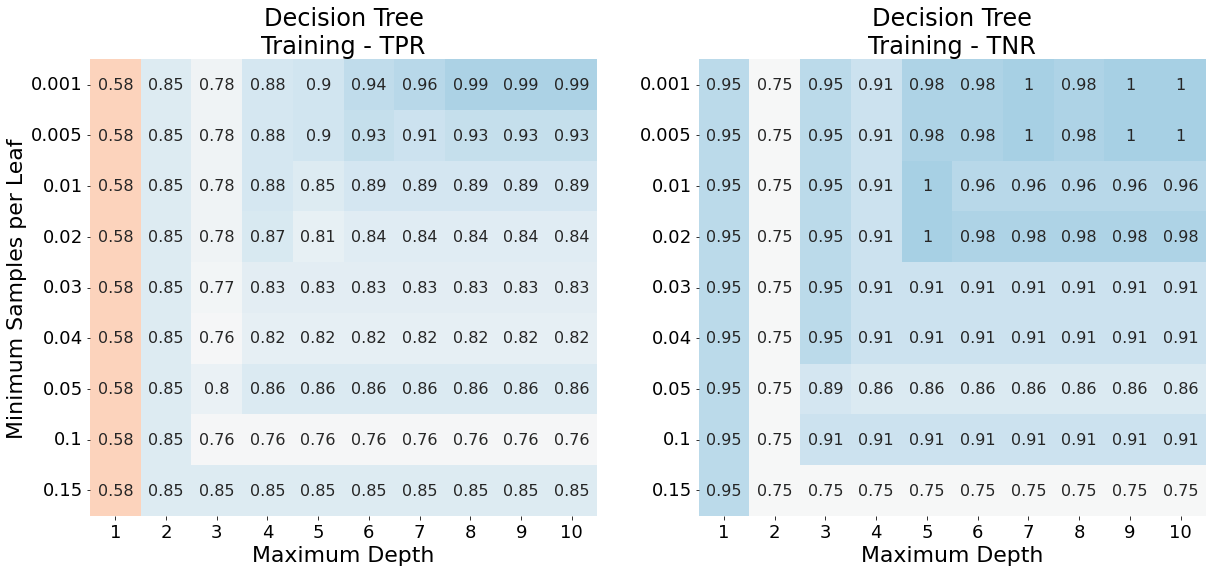

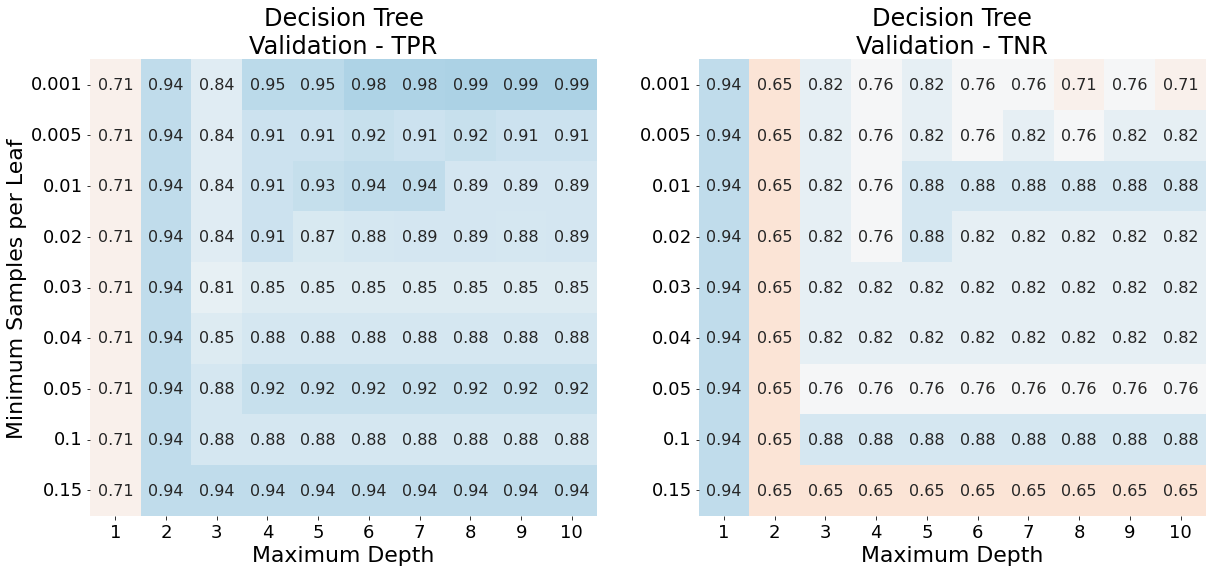

In [24]:
plot_heatmap(dict_dt_metrics, l1=list_max_depth_dt, l2=list_min_samples_leaf_dt, name1='max_depth', name2='min_samples_leaf',
             t1='Maximum Depth', t2='Minimum Samples per Leaf', model_name='Decision_Tree')

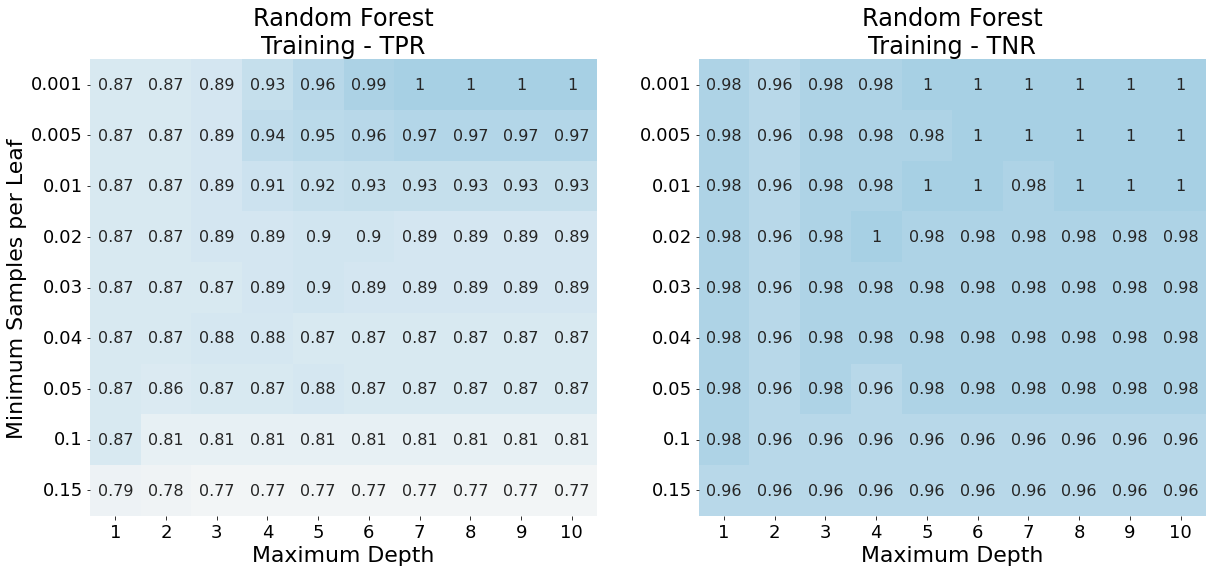

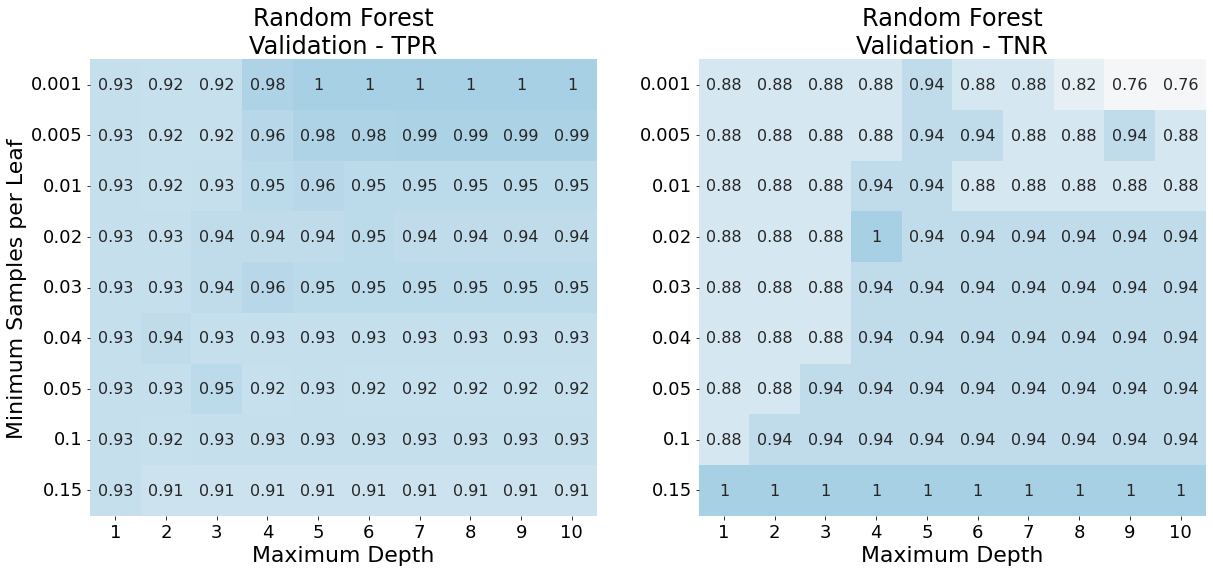

In [25]:
plot_heatmap(dict_rf_metrics, l1=list_max_depth_rf, l2=list_min_samples_leaf_rf, name1='max_depth', name2='min_samples_leaf',
             t1='Maximum Depth', t2='Minimum Samples per Leaf', model_name='Random_Forest')

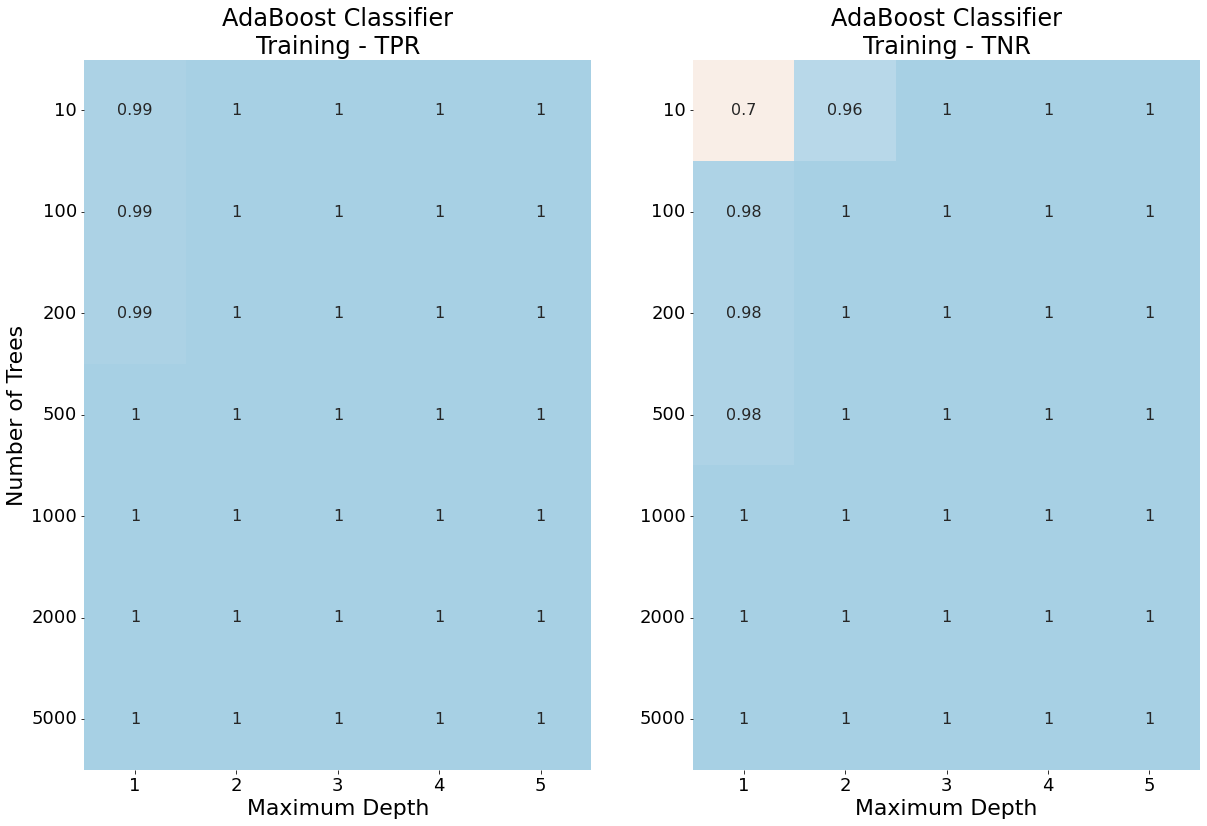

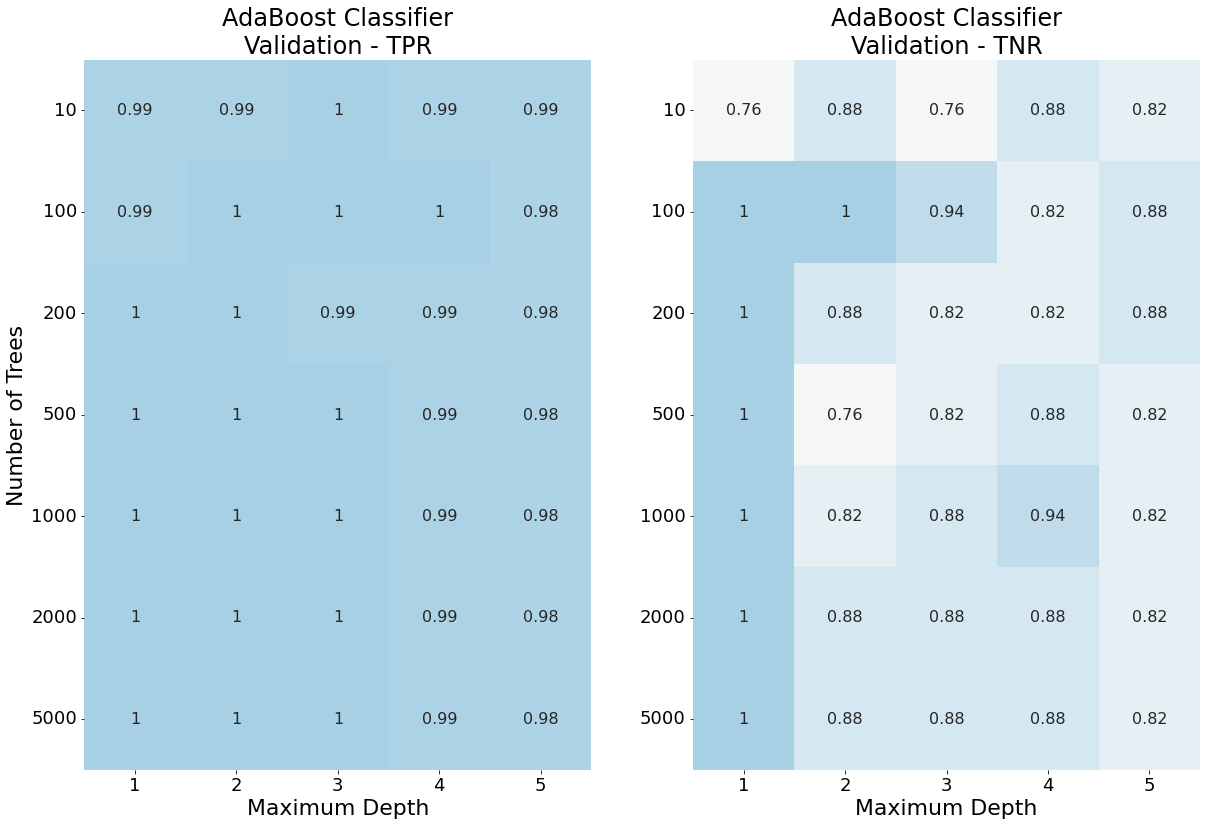

In [26]:
plot_heatmap(dict_ab_metrics, l1=list_max_depth_ab, l2=list_n_estimators_ab, name1='max_depth', name2='n_estimators',
             t1='Maximum Depth', t2='Number of Trees', model_name='AdaBoost_Classifier')

## Choice of models

Criteria for selecting models is based on the validation TPR and TNR metrics, such that we are maximising the sum of TPR and TNR and to keep them as close to each other as possible. The models should be also as simple as possible (depths, leaves...). As a result we choose 3 models: 
* Decision Tree with a max depth of 3, min samples per leaf of 0.10.
* Random Forest with a max depth of 4, min samples per leaf of 0.03.
* AdaBoost with depth of 1 and number of trees 1000.

In [27]:
chosen_models = [
    'Decision_Tree', 'Random_Forest', 'AdaBoost_Classifier'
]

In [28]:
dict_chosen_models = {
    'Decision_Tree': dict_dt_models['Decision_Tree_max_depth_3_min_samples_leaf_0.1'],
    'Random_Forest': dict_rf_models['Random_Forest_max_depth_4_min_samples_leaf_0.03'],
    'AdaBoost_Classifier': dict_ab_models['AdaBoost_Classifier_max_depth_1_n_estimators_200']
}

In [29]:
def get_test_metrics(model, x_test, y_test):
    y_test_pred = (pd.Series(model.predict(x_test), index=y_test.index) > 0.5).astype('int')
    tpr_test = np.round((y_test_pred[y_test > 0.5] == 1).astype('float').mean(), 4)
    fpr_test = np.round((y_test_pred[y_test > 0.5] == 0).astype('float').mean(), 4)
    tnr_test = np.round((y_test_pred[y_test < 0.5] == 0).astype('float').mean(), 4)
    fnr_test = np.round((y_test_pred[y_test < 0.5] == 1).astype('float').mean(), 4)
    precision = (y_test_pred.where(y_test > 0.5)).sum() / y_test_pred.sum()
    recall = (y_test_pred.where(y_test > 0.5)).sum() / y_test.sum()
    f1_test = np.round(2*(precision*recall) / (precision+recall), 2)
    metrics = pd.Series({
        'tpr_test': tpr_test, 'tnr_test': tnr_test,
        'fpr_test': fpr_test, 'fnr_test': fnr_test,
        'f1_test': f1_test
    })
    return metrics

In [30]:
dict_test_metrics = {}
for model in chosen_models:
    dict_test_metrics[model] = get_test_metrics(
        model=dict_chosen_models[model],
        x_test=test_data[list_inputs], y_test=test_data[list_outputs[0]])
pd.DataFrame(dict_test_metrics).T * 100.

,tpr_test,tnr_test,fpr_test,fnr_test,f1_test
Decision_Tree,79.07,87.50,20.93,12.50,87.0
Random_Forest,93.02,100.00,6.98,0.00,96.0
AdaBoost_Classifier,100.00,93.75,0.00,6.25,99.0


# Feature importances

In [31]:
list_inputs_translated = list_inputs

## Permutation importance

We used 10000 shuffles.

In [32]:
from sklearn.inspection import permutation_importance

In [33]:
n_perm = 10000
import pickle
try:
    f = open('permutation_importance_training_{}_en.pkl'.format(n_perm), 'rb')
    dict_permutation_importance_training = pickle.load(f)
    f.close()
    f = open('permutation_importance_validation_{}_en.pkl'.format(n_perm), 'rb')
    dict_permutation_importance_validation = pickle.load(f)
    f.close()
    f = open('permutation_importance_testing_{}_en.pkl'.format(n_perm), 'rb')
    dict_permutation_importance_testing = pickle.load(f)
    f.close()
except:
    dict_permutation_importance_training = {}
    dict_permutation_importance_validation = {}
    dict_permutation_importance_testing = {}
    for model in chosen_models:

        dict_permutation_importance_training[model] = permutation_importance(
            dict_chosen_models[model],
            train_data[list_inputs], train_data[list_outputs[0]],
            n_repeats=n_perm, random_state=42)
        dict_permutation_importance_validation[model] = permutation_importance(
            dict_chosen_models[model],
            val_data[list_inputs], val_data[list_outputs[0]],
            n_repeats=n_perm, random_state=42)
        dict_permutation_importance_testing[model] = permutation_importance(
            dict_chosen_models[model],
            test_data[list_inputs], test_data[list_outputs[0]],
            n_repeats=n_perm, random_state=42)
        print(model)
    f = open('permutation_importance_training_{}_en.pkl'.format(n_perm), 'wb')
    pickle.dump(dict_permutation_importance_training, f)
    f.close()
    f = open('permutation_importance_validation_{}_en.pkl'.format(n_perm), 'wb')
    pickle.dump(dict_permutation_importance_validation, f)
    f.close()
    f = open('permutation_importance_testing_{}_en.pkl'.format(n_perm), 'wb')
    pickle.dump(dict_permutation_importance_testing, f)
    f.close()

In [34]:
def feature_importance_plots(dict_permutation_importance, dataset='val'):
    f, ax = plt.subplots(figsize=(20,10))
    f_mean = pd.DataFrame({
        model: pd.Series(dict_permutation_importance[model].importances_mean, index=list_inputs)
        for model in chosen_models
    })
    f_std = pd.DataFrame({
        model: pd.Series(dict_permutation_importance[model].importances_std, index=list_inputs)
        for model in chosen_models
    })
    f_mean[chosen_models].plot(yerr=f_std, kind='bar', capsize=4, ax=ax)
    if dataset == 'train':
        a = ' (Training)'
    elif dataset == 'val':
        a = ' (Validation)'
    else:
        a = ' (Testing)'
    ax.set_title("Variable Importance"+a, fontsize=title_size)
    ax.set_ylabel("Importance", fontsize=label_size)
    ax.set_xlabel("TFI Question (independent variable)", fontsize=label_size)
    ax.legend([model.replace('_', ' ') for model in chosen_models],
              loc=0, fontsize=label_size)
    ax.tick_params(axis="x", labelsize=ticklabel_size)
    ax.tick_params(axis="y", labelsize=ticklabel_size)
    plt.show()

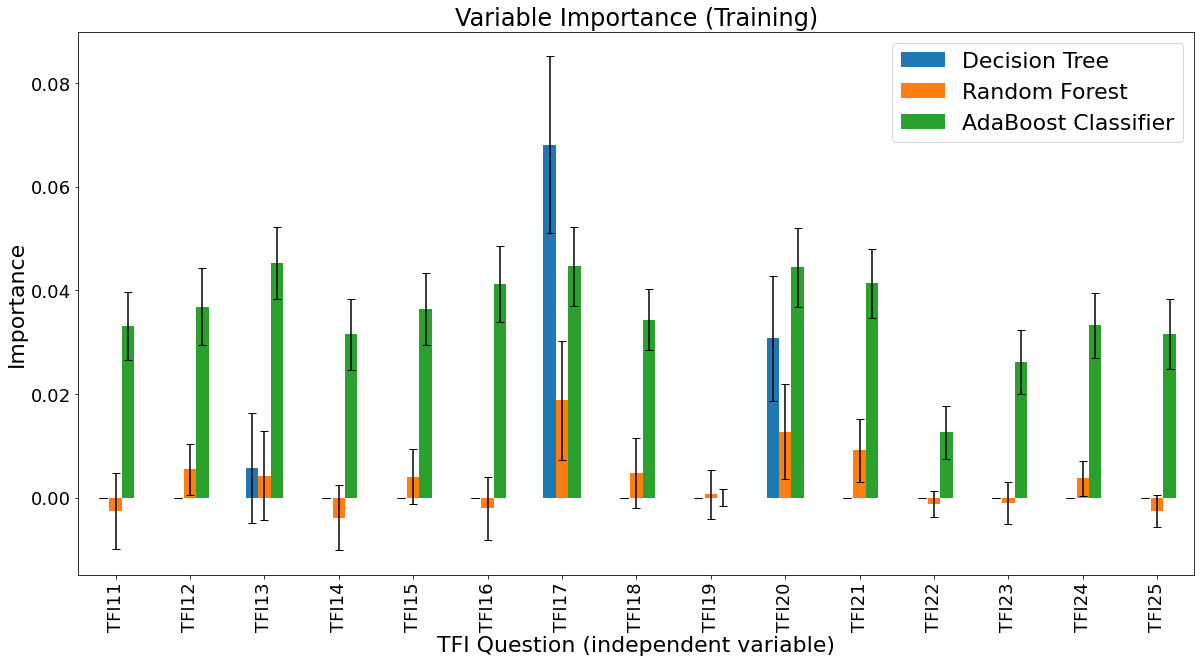

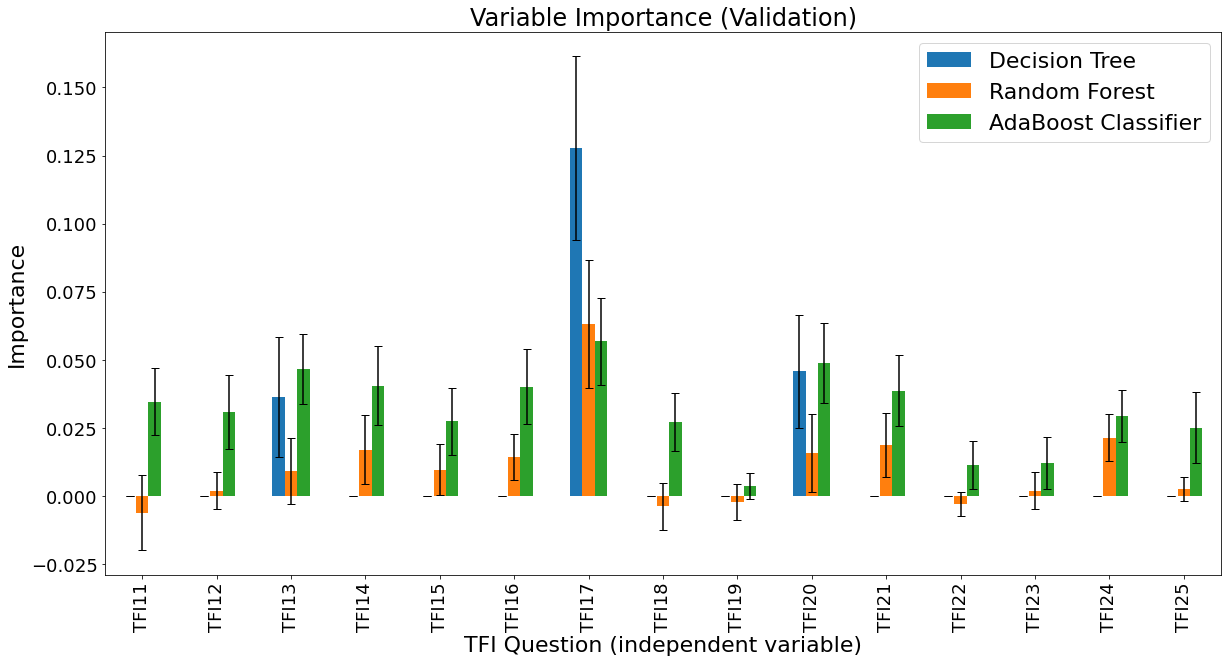

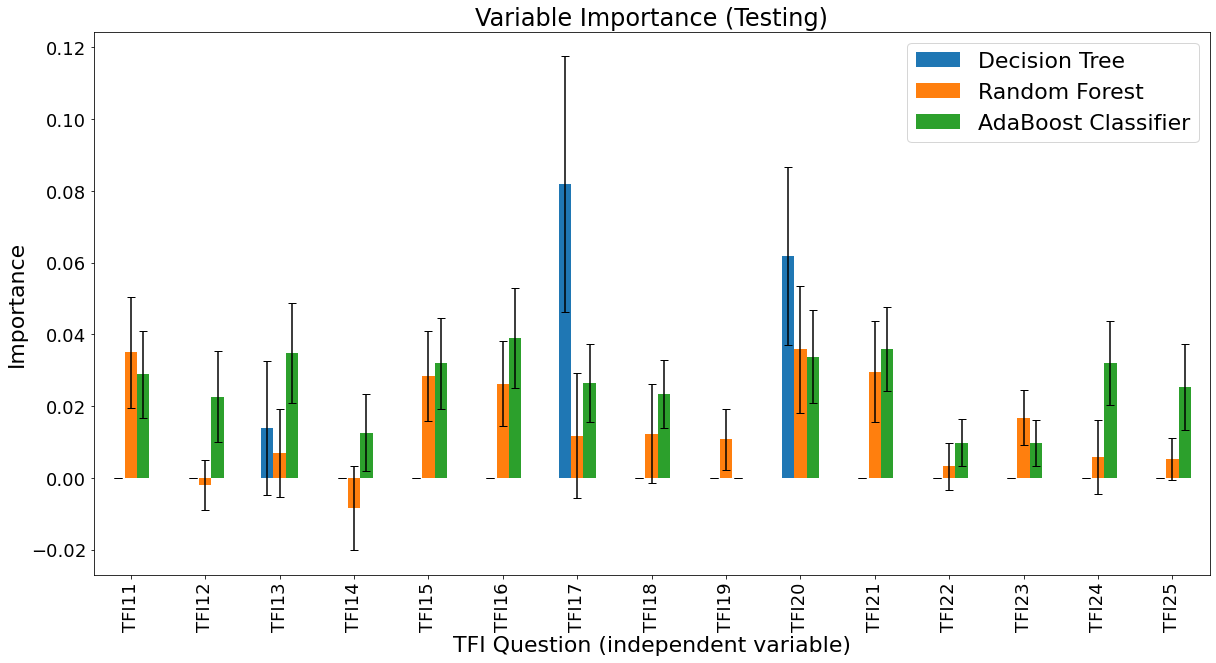

In [35]:
feature_importance_plots(dict_permutation_importance_training, 'train')
feature_importance_plots(dict_permutation_importance_validation, 'val')
feature_importance_plots(dict_permutation_importance_testing, 'test')

In [36]:
def importance_abs_table_all_z_new(permutation_importances, data_type='validation'):
    import scipy
    from scipy import stats
    from statsmodels.stats import weightstats as stests
    
    f, axes = plt.subplots(nrows=3, figsize=(20, 15))
    main_title = r'Mean, standard deviation and $\it{z}$ statistic'+' ({})'.format(data_type)
    for model_, model in enumerate(chosen_models):
        df = pd.DataFrame(
            permutation_importances[model].importances,
            index=list_inputs
        ).T
        sec_title = model.replace('_', ' ')
        ax = axes[model_]   
        table = {}
        table_annot = {}
        for i, i_ in enumerate(list_inputs):
            m = permutation_importances[model]['importances_mean'][i]
            s = permutation_importances[model]['importances_std'][i]
            if s == 0:
                m = 0.
                s = np.nan
                z = np.nan
                p = np.nan
            else:
                z, p = stests.ztest(df[i_], x2=None, alternative='larger', ddof=1, value=0)
            table[i_] = pd.Series({
                'mean': m,
                'standard\ndeviation': s/10,
                r'$z$ ($p$)': z/n_perm
            })
            table_annot[i_] = pd.Series({
                'mean': np.round(m, 3),
                'standard\ndeviation': np.round(s, 3),
                r'$z$ ($p$)': (
                    '{:.1f}\n({:.2f})'.format(z, p) if z is not np.nan else ''
                ),
            })
        table = pd.DataFrame(table).round(3)
        table_annot = pd.DataFrame(table_annot)
        sns.heatmap(table,
                    vmin=-.08, vmax=.08, fmt='',
                    square=True, annot=table_annot, cmap='RdBu_r',
                    ax=ax,cbar=False, annot_kws={'fontsize': annot_size*1.4})
        for i in range(5):
            if i == 1:
                ax.axhline(i, color='k', linestyle='--')
                continue
            ax.axhline(i, color='k', linestyle='-')
        ax.axvline(8., color='k', linestyle='--')
        ax.axvline(12., color='k', linestyle='--')
        if model_ == 0:
            title = main_title + '\n' + sec_title
        else:
            title = sec_title
        if model_ == len(chosen_models) - 1:
            ax.set_xlabel('Variable', fontsize=label_size)
        else:
            ax.set_xticklabels([])
        ax.set_title(title, fontsize=title_size)
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelsize=ticklabel_size, rotation=70)
        ax.tick_params(axis='y', labelsize=ticklabel_size, rotation=0)
    plt.show()

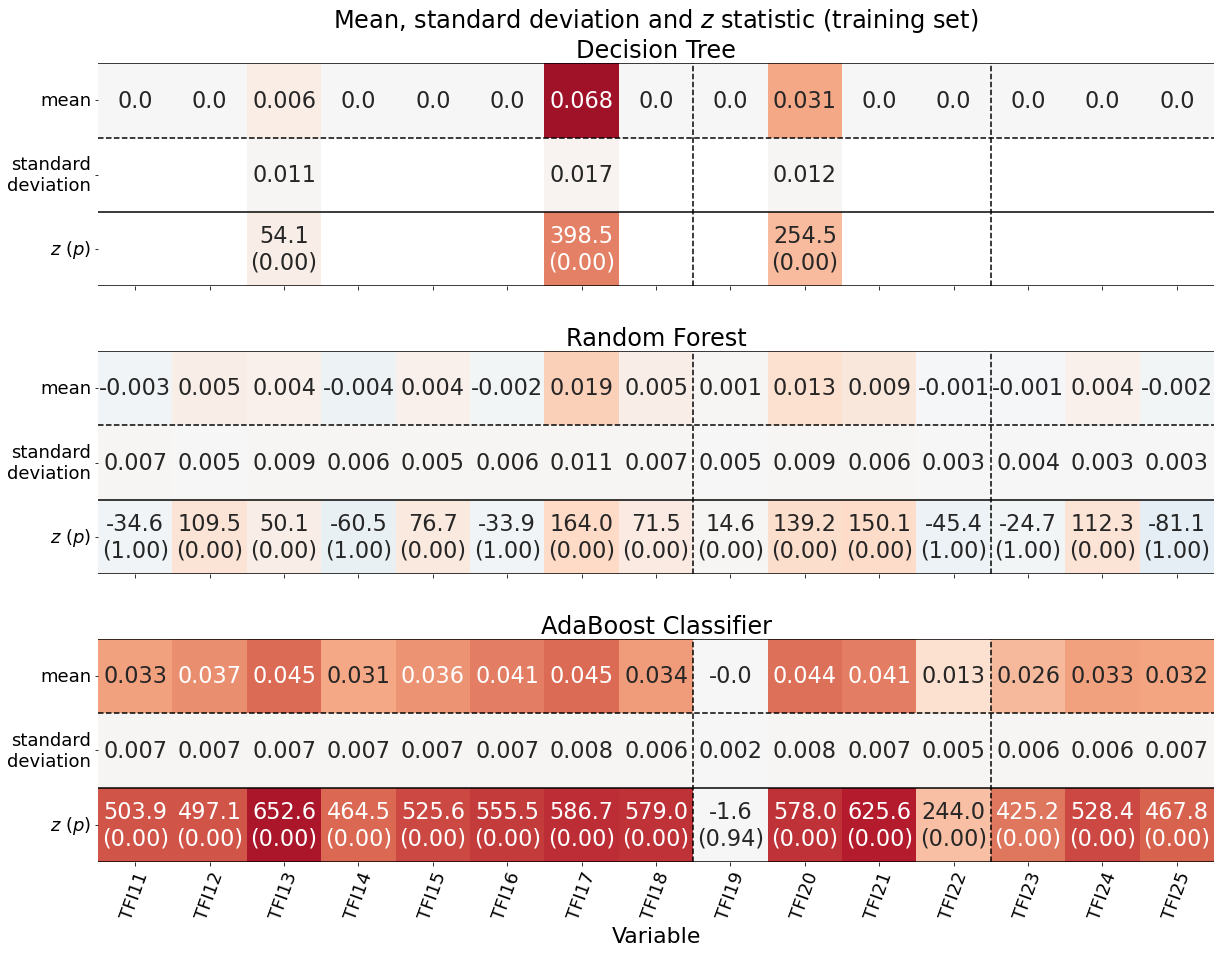

In [37]:
importance_abs_table_all_z_new(dict_permutation_importance_training, 'training set')

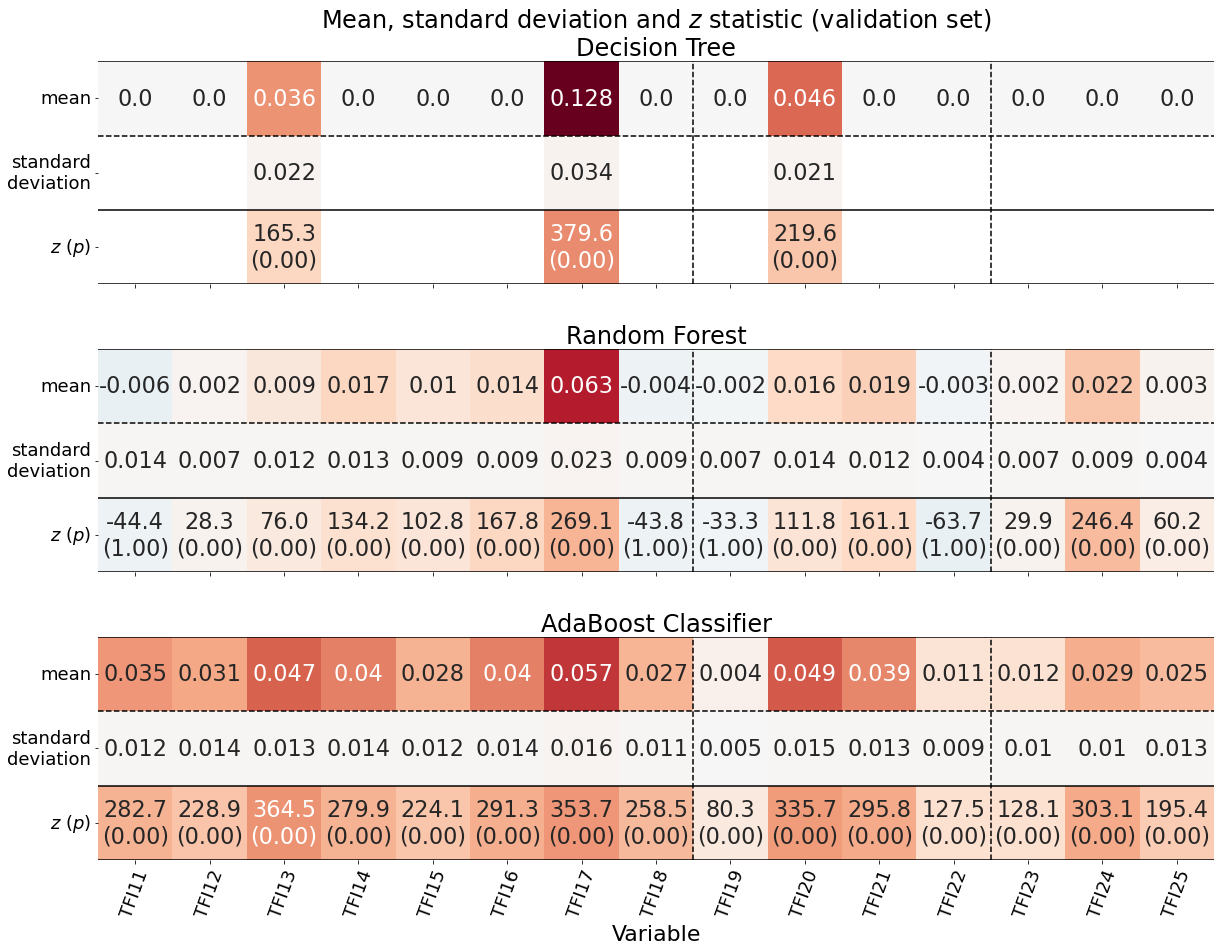

In [38]:
importance_abs_table_all_z_new(dict_permutation_importance_validation, 'validation set')

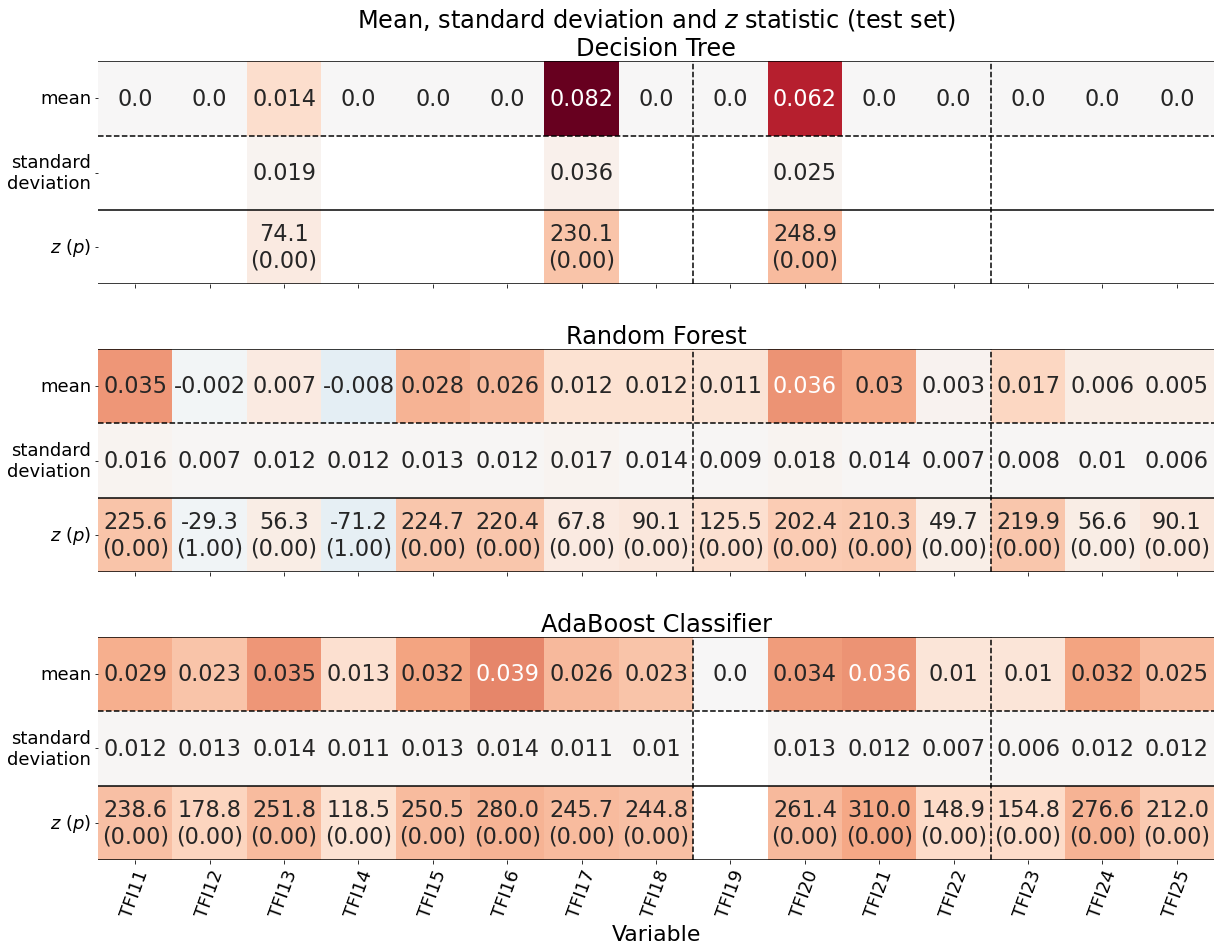

In [39]:
importance_abs_table_all_z_new(dict_permutation_importance_testing, 'test set')

In [40]:
dict_permutation_importance_validation[
    'AdaBoost_Classifier'
].importances_mean / (dict_permutation_importance_validation[
    'AdaBoost_Classifier'
].importances_std / np.sqrt(n_perm))

array([282.72820299, 228.86365018, 364.47291145, 279.90670764,
       224.13551545, 291.27559807, 353.73564947, 258.49265957,
        80.34605096, 335.75501576, 295.82249936, 127.50076395,
       128.11373432, 303.11040253, 195.37172436])

In [41]:
from scipy.stats import ttest_ind

In [42]:
def matrix_plot(permutation_importance, title, prec=2):
    from scipy import stats
    from statsmodels.stats import weightstats as stests
    df_importance = pd.DataFrame(permutation_importance.importances, index=list_inputs).T#[lp]
    lp_ = []
    for i, i_ in enumerate(list_inputs):
        z, p = stests.ztest(df_importance[i_], x2=None, alternative='larger', ddof=1, value=0)
        ki = (i_ + '*' if p < 0.05 else i_)
        lp_.append(ki)
    
    stds = pd.Series(permutation_importance.importances_std, index=lp_)
    lp = stds[stds >= 1e-6].index
    k = len(lp) * (len(lp) - 1) / 2
    required_p_value = 0.05 / k # 1 - (1 - 0.05)**(1/k)
    
    df_importance = pd.DataFrame(permutation_importance.importances, index=lp_).T[lp]
    df_zstat = {i_: {j_: np.nan for j_ in lp} for i_ in lp}
    df_p = {i_: {j_: np.nan for j_ in lp} for i_ in lp}
    df_annot = {i_: {j_: np.nan for j_ in lp} for i_ in lp}
    means = pd.Series(permutation_importance.importances_mean, index=lp_)[lp]
    for i, i_ in enumerate(lp):
        for j, j_ in enumerate(lp):
            if i == j:
                continue
            s, p = stests.ztest(df_importance[i_], x2=df_importance[j_],
                                alternative='two-sided', ddof=1, value=0)
            df_zstat[i_][j_] = s
            df_p[i_][j_] = p
            delta = means[i_] - means[j_]
            p_ = 'insign.' if p > required_p_value else 'p*'
            if prec == 3:
                df_annot[i_][j_] = r'$\Delta$: ' +'{:.3f}\nZ: {:.0f}\n{}'.format(
                    np.round(delta, 3), np.round(s, 3), p_)
            else:
                df_annot[i_][j_] = r'$\Delta$: ' +'{:.2f}\nZ: {:.0f}\n{}'.format(
                    np.round(delta, 3), np.round(s, 3), p_)
    df_zstat = pd.DataFrame(df_zstat).T
    df_p = pd.DataFrame(df_p).T
    df_annot = pd.DataFrame(df_annot).T
    if len(lp) < 10:
        fsize = 6
    else:
        fsize = len(lp) + 8
        if prec == 3:
            fsize = fsize + 4
    f, ax = plt.subplots(figsize=(fsize,fsize))
    sns.heatmap(df_p[lp].T[lp].round(5),
                vmin=-required_p_value * 2, vmax=required_p_value * 5, fmt='',
                square=True, annot=df_annot, cmap='RdBu_r',
                ax=ax,cbar=False, annot_kws={"fontsize": annot_size*1.3})
    ax.set_title(
        title + '\n' + r'Significance level: p $\leq$ ' + "{}\nBonferroni correction, k = {}".format(
        np.round(required_p_value, 4), int(k)), fontsize=title_size*1.3)
    ax.set_ylabel('Variable (A)', fontsize=label_size*1.3)
    ax.set_xlabel('Variable (B)', fontsize=label_size*1.3)
    for i in range(len(lp) + 1):
        plt.axhline(i, color='k')
        plt.axvline(i, color='k')
    ax.tick_params(axis="x", labelsize=ticklabel_size*1.3, rotation=70)
    ax.tick_params(axis="y", labelsize=ticklabel_size*1.3, rotation=0)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:746: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff


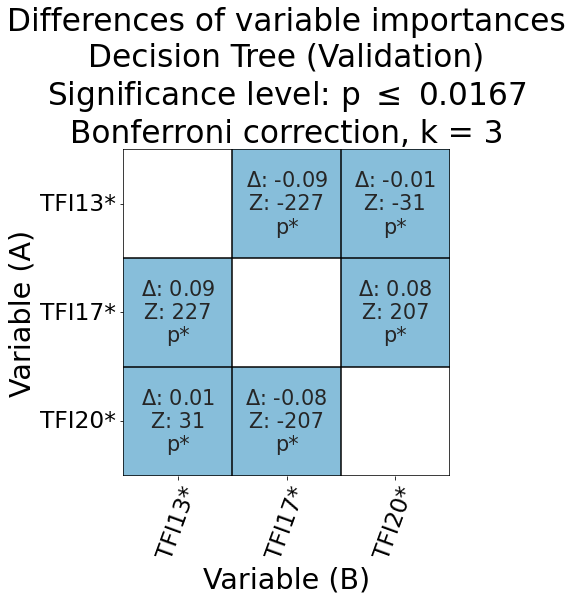

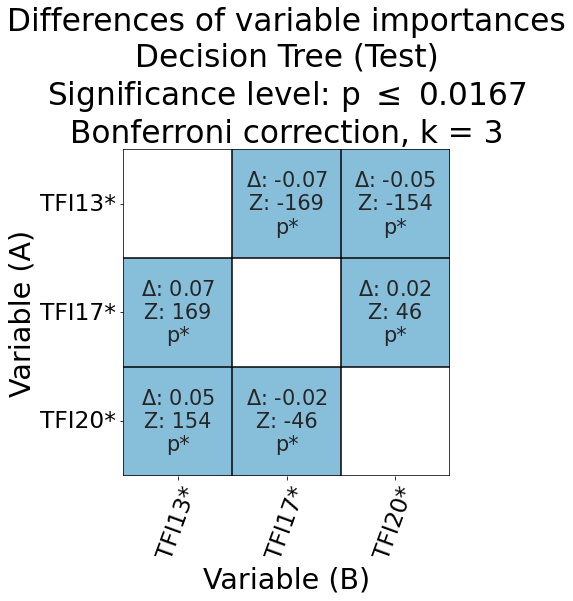

In [43]:
matrix_plot(dict_permutation_importance_validation['Decision_Tree'],
            'Differences of variable importances\nDecision Tree (Validation)')

matrix_plot(dict_permutation_importance_testing['Decision_Tree'],
            'Differences of variable importances\nDecision Tree (Test)')

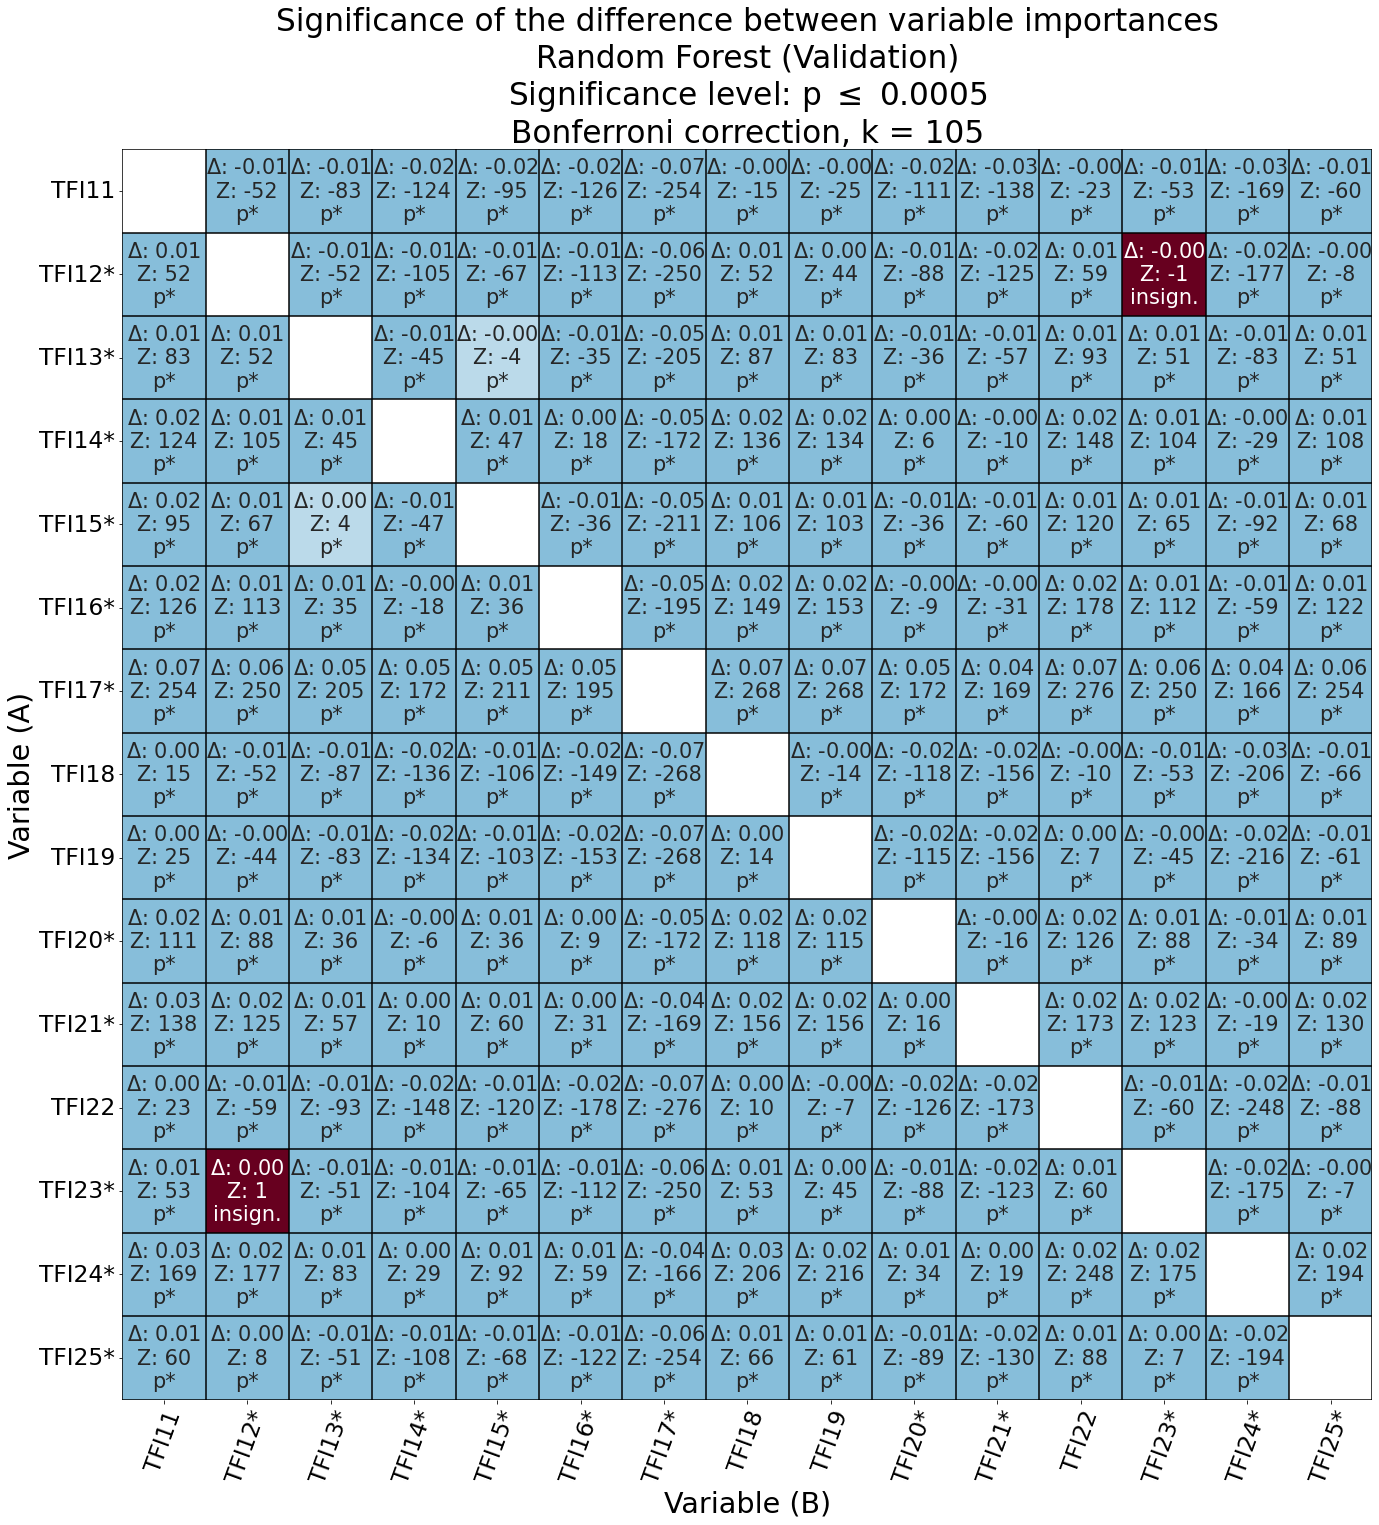

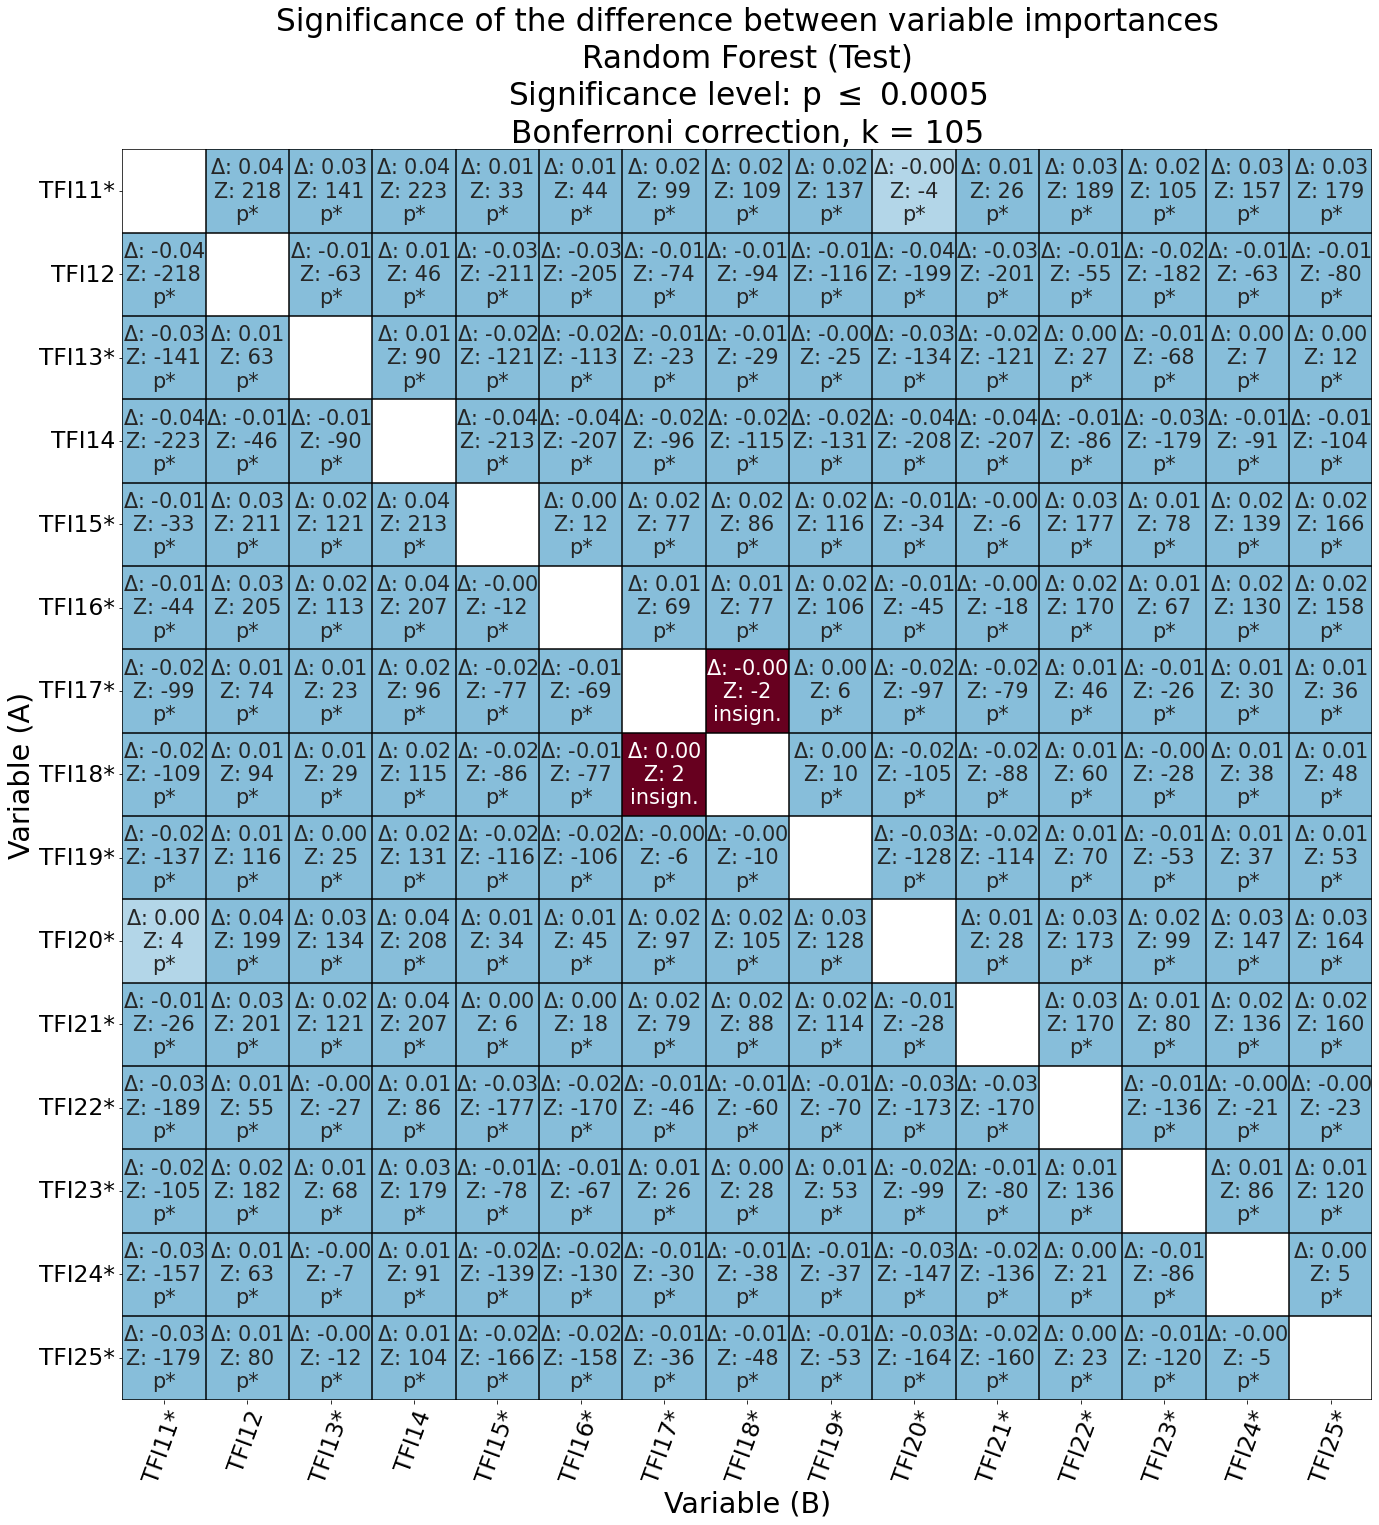

In [44]:
matrix_plot(dict_permutation_importance_validation['Random_Forest'],
            'Significance of the difference between variable importances\nRandom Forest (Validation)')

matrix_plot(dict_permutation_importance_testing['Random_Forest'],
            'Significance of the difference between variable importances\nRandom Forest (Test)')

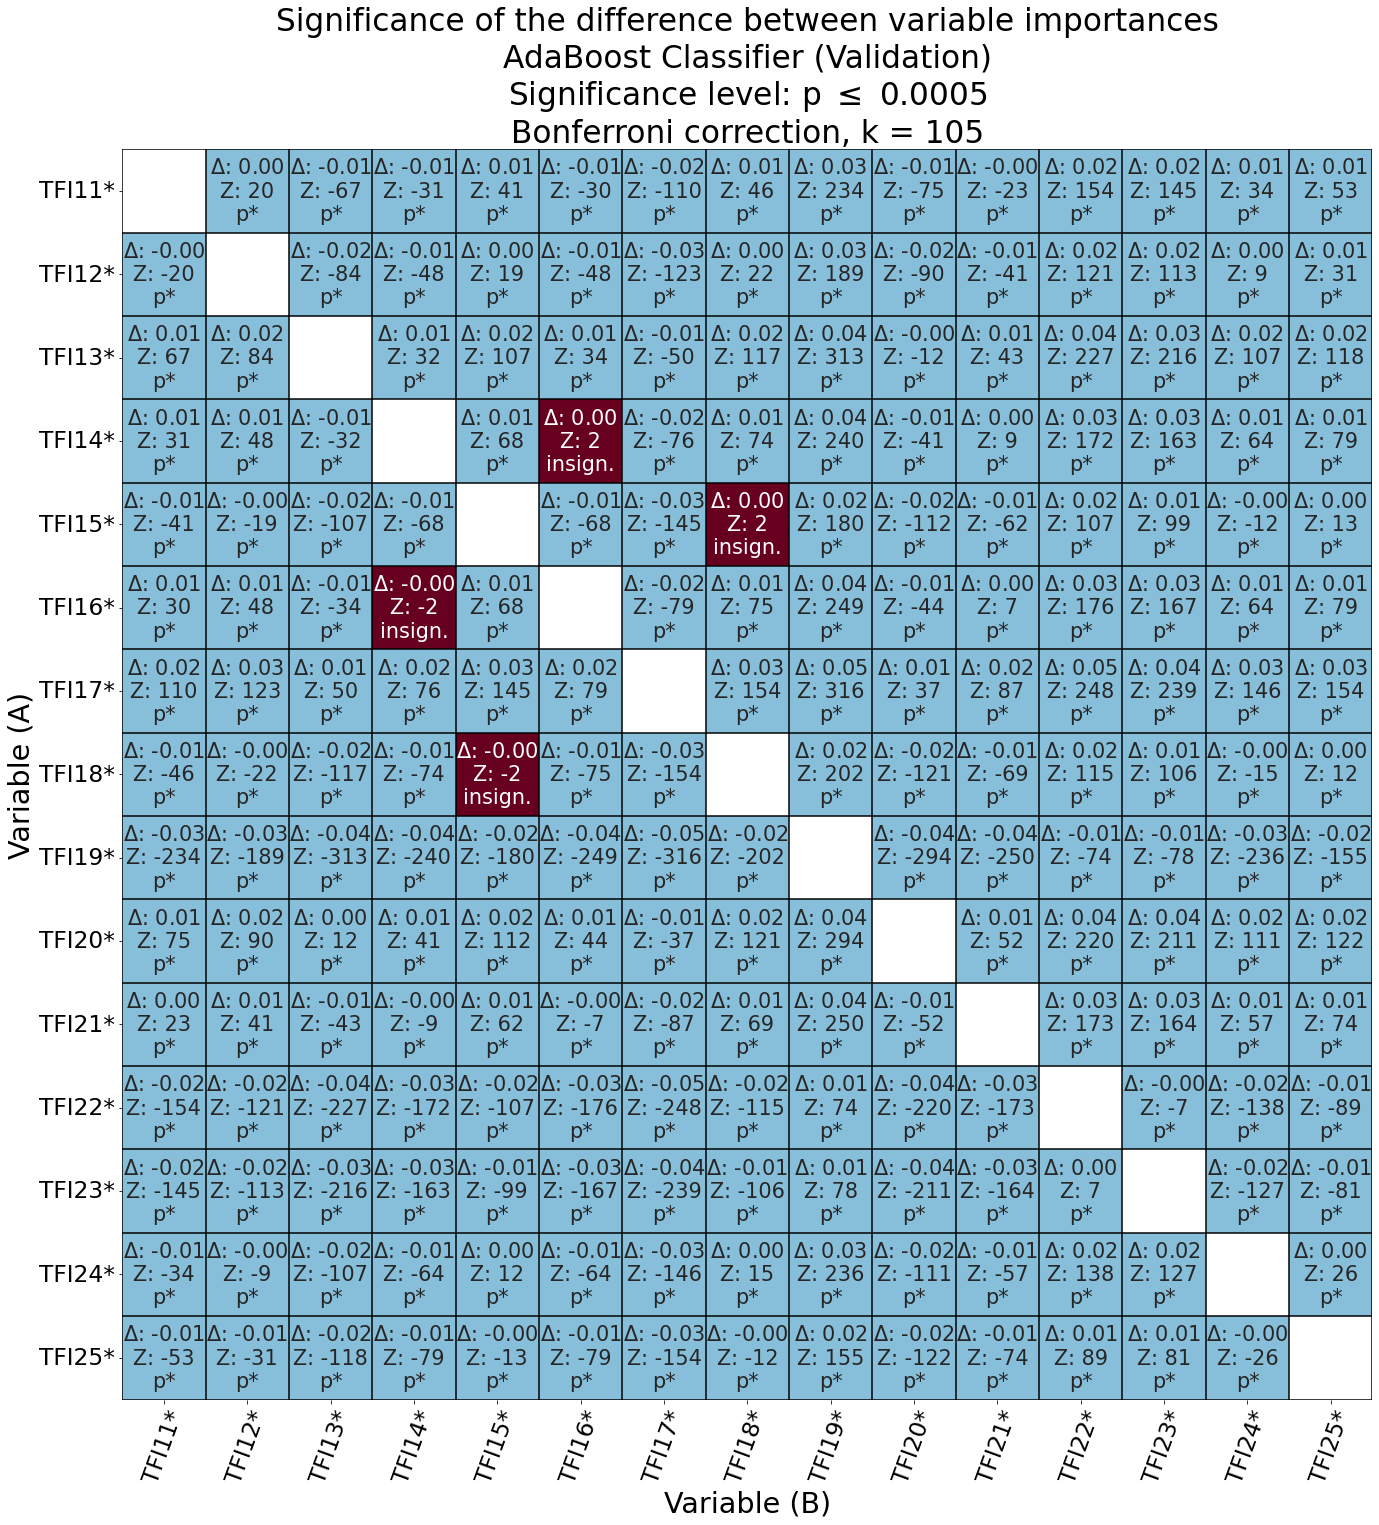

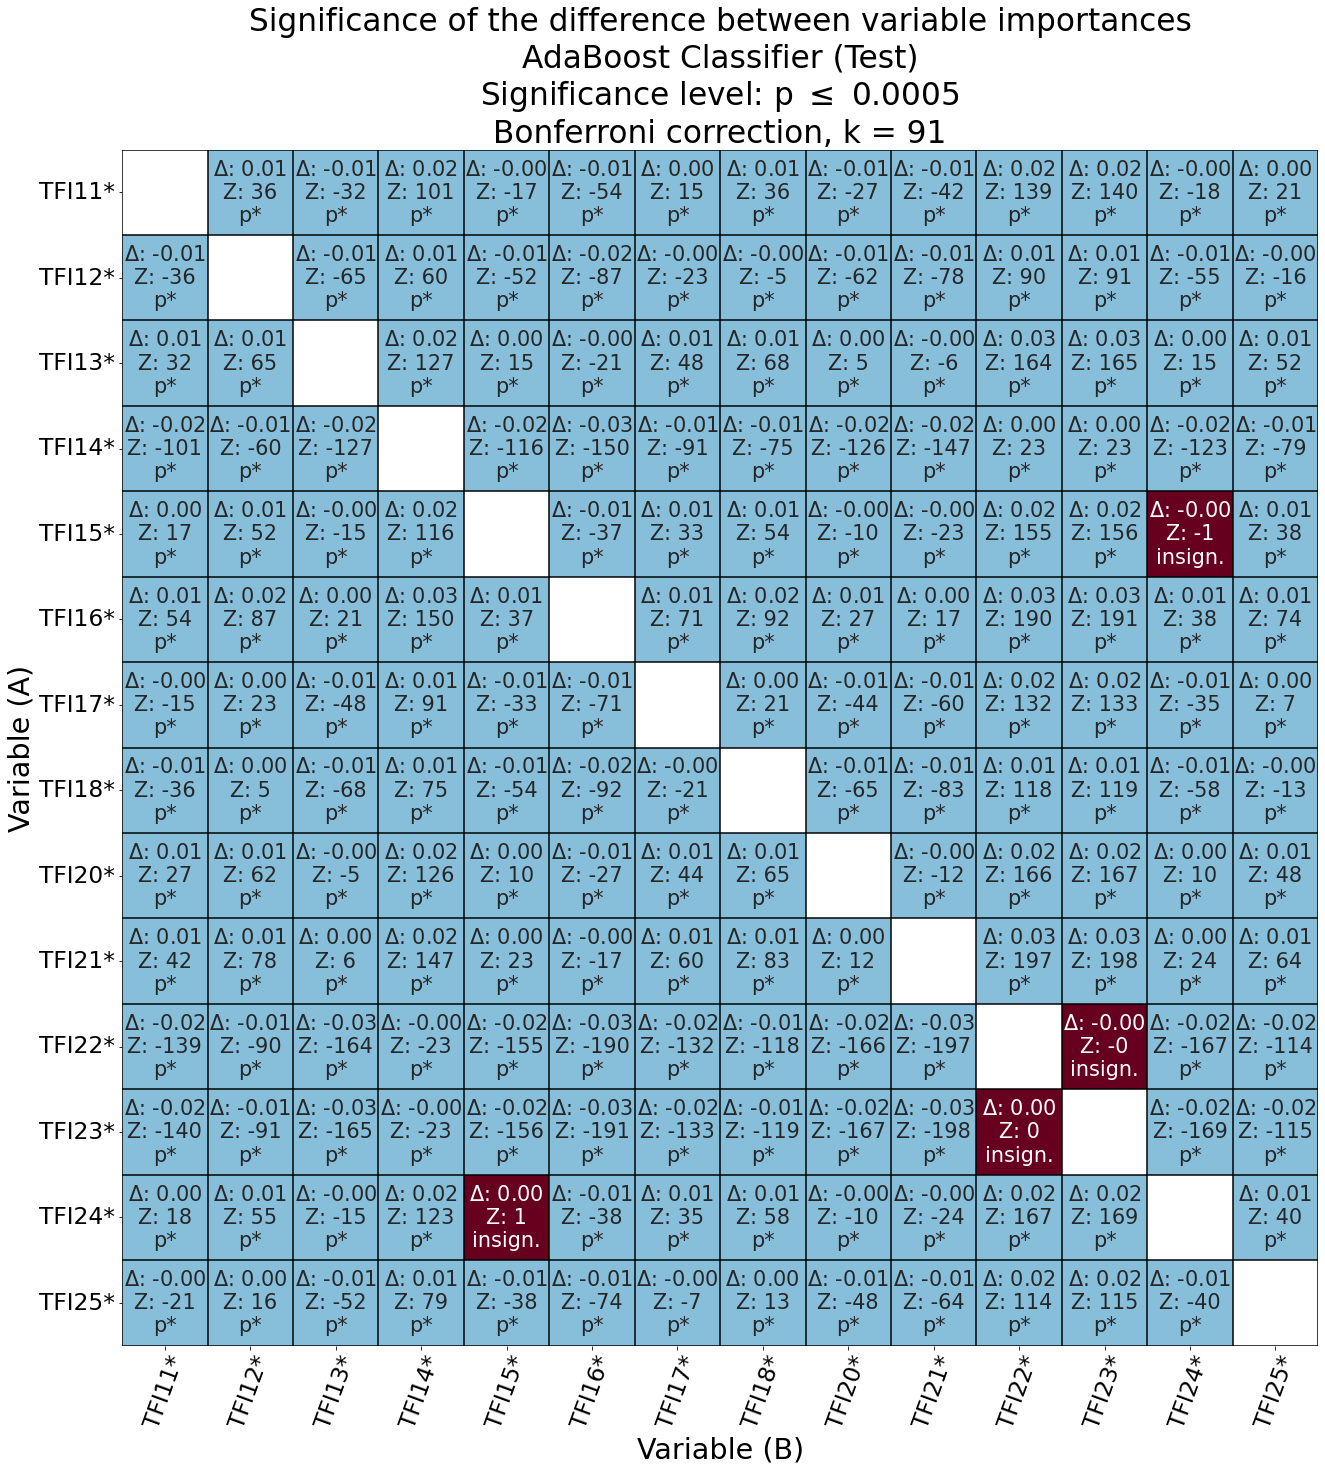

In [45]:
matrix_plot(dict_permutation_importance_validation['AdaBoost_Classifier'],
            'Significance of the difference between variable importances\nAdaBoost Classifier (Validation)')

matrix_plot(dict_permutation_importance_testing['AdaBoost_Classifier'],
            'Significance of the difference between variable importances\nAdaBoost Classifier (Test)')